In [32]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torchbnn as bnn

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




### Variational Inference

In [33]:
df = pd.read_csv('GlobalWeatherRepository.csv')
print(df.columns.tolist())
# Selecting features that logically affect temperature
features = ['humidity', 'wind_kph', 'pressure_mb', 'precip_mm', 'cloud', 'visibility_km', 'uv_index']
target = 'temperature_celsius'

X = df[features].values
y = df[target].values.reshape(-1, 1)

# Scaling is crucial for BNN convergence
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

['country', 'location_name', 'latitude', 'longitude', 'timezone', 'last_updated_epoch', 'last_updated', 'temperature_celsius', 'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination']


In [34]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=len(features), out_features=128),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=128, out_features=64),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=1),
)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [35]:
epochs = 1000
for epoch in range(epochs):
    pred = model(X_train)
    mse = mse_loss(pred, y_train)
    kl = kl_loss(model)
    cost = mse + kl_weight * kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total Loss: {cost.item():.4f} | MSE: {mse.item():.4f}")

Epoch 0 | Total Loss: 1.3378 | MSE: 1.3340
Epoch 100 | Total Loss: 0.5967 | MSE: 0.5912
Epoch 200 | Total Loss: 0.4803 | MSE: 0.4745
Epoch 300 | Total Loss: 0.4761 | MSE: 0.4700
Epoch 400 | Total Loss: 0.4473 | MSE: 0.4408
Epoch 500 | Total Loss: 0.4278 | MSE: 0.4208
Epoch 600 | Total Loss: 0.4386 | MSE: 0.4316
Epoch 700 | Total Loss: 0.4569 | MSE: 0.4498
Epoch 800 | Total Loss: 0.4193 | MSE: 0.4119
Epoch 900 | Total Loss: 0.4126 | MSE: 0.4051


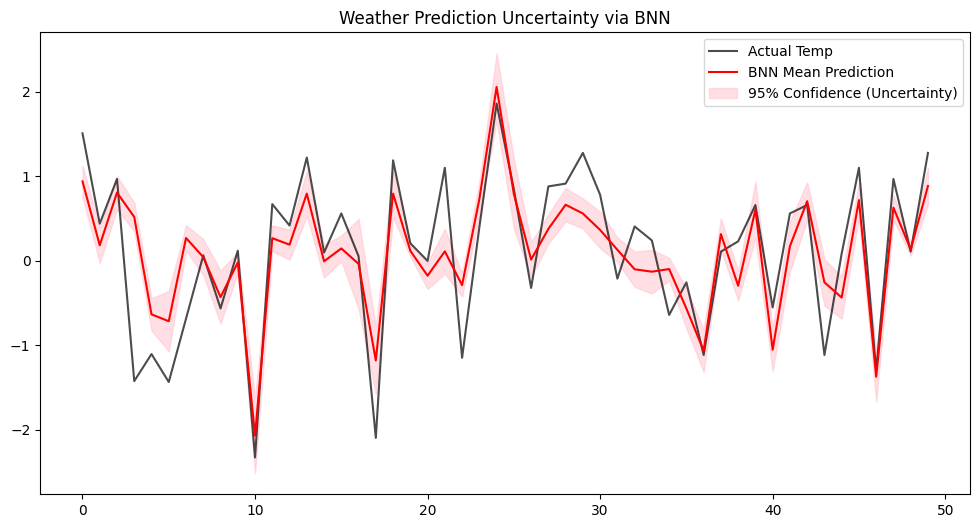

In [36]:
# Predictive Inference
model.eval()
iterations = 100
predictions = np.zeros((iterations, len(X_test)))

with torch.no_grad():
    for i in range(iterations):
        # Each pass samples different weights from the learned distribution
        predictions[i] = model(X_test).numpy().flatten()

# Calculate Mean and Std Dev
prediction_mean = predictions.mean(axis=0)
prediction_std = predictions.std(axis=0)

# Plotting the first 50 samples
plt.figure(figsize=(12,6))
plt.plot(y_test[:50], 'black', label='Actual Temp', alpha=0.7)
plt.plot(prediction_mean[:50], 'red', label='BNN Mean Prediction')
plt.fill_between(range(50), 
                 prediction_mean[:50] - 2*prediction_std[:50], 
                 prediction_mean[:50] + 2*prediction_std[:50], 
                 color='pink', alpha=0.5, label='95% Confidence (Uncertainty)')
plt.title("Weather Prediction Uncertainty via BNN")
plt.legend()
plt.show()

### MCMC

In [37]:


# 1. Tiền xử lý dữ liệu (Giống phần trước)
df = pd.read_csv('GlobalWeatherRepository.csv')
features = ['humidity', 'wind_kph', 'pressure_mb', 'cloud', 'visibility_km', 'uv_index']
target = 'temperature_celsius'

df = df.dropna(subset=features + [target])
X = df[features].values
y = df[target].values.reshape(-1, 1)

scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
# Chuyển sang Tensor
X_data = torch.tensor(X_scaled, dtype=torch.float32)
y_data = torch.tensor(y, dtype=torch.float32).squeeze()

# Để MCMC chạy nhanh, ta lấy một tập con (ví dụ 200 dòng)
X_train = X_data[:200]
y_train = y_data[:200]

# 2. Định nghĩa mô hình Bayesian (Stochastic Function)
def model(X, y=None):
    # Khai báo các Prior (Niềm tin ban đầu) cho trọng số
    input_dim = X.shape[1]
    hidden_dim = 16 # MCMC nên dùng mạng nhỏ để nhanh hơn
    
    # Trọng số lớp 1
    w1_prior = dist.Normal(torch.zeros(input_dim, hidden_dim), torch.ones(input_dim, hidden_dim)).to_event(2)
    b1_prior = dist.Normal(torch.zeros(hidden_dim), torch.ones(hidden_dim)).to_event(1)
    
    # Trọng số lớp 2 (Output)
    w2_prior = dist.Normal(torch.zeros(hidden_dim, 1), torch.ones(hidden_dim, 1)).to_event(2)
    b2_prior = dist.Normal(torch.zeros(1), torch.ones(1)).to_event(1)
    
    # Lấy mẫu trọng số từ Priors
    w1 = pyro.sample("w1", w1_prior)
    b1 = pyro.sample("b1", b1_prior)
    w2 = pyro.sample("w2", w2_prior)
    b2 = pyro.sample("b2", b2_prior)
    
    # Kiến trúc mạng: Linear -> ReLU -> Linear
    h = torch.relu(X @ w1 + b1)
    mu = (h @ w2 + b2).squeeze()
    
    # Độ nhiễu của dữ liệu (Aleatoric uncertainty)
    sigma = pyro.sample("sigma", dist.HalfNormal(1.0))
    
    # Likelihood: So khớp với dữ liệu thực tế
    with pyro.plate("data", X.shape[0]):
        return pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

# 3. Chạy MCMC với thuật toán NUTS
pyro.clear_param_store()
# NUTS là thuật toán lấy mẫu tự động điều chỉnh rất mạnh mẽ
nuts_kernel = NUTS(model)

# Khởi tạo trình lấy mẫu MCMC
# num_samples: số lượng bộ trọng số thu thập được
# warmup_steps: số bước chạy đà để thuật toán tìm đúng vùng "ngon"
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=100, num_chains=1)

print("Đang bắt đầu lấy mẫu MCMC (Quá trình này có thể mất vài phút)...")
mcmc.run(X_train, y_train)

# 4. Dự đoán và Phân tích kết quả
# Lấy các mẫu trọng số đã học được
posterior_samples = mcmc.get_samples()

def predict(X):
    # Với mỗi bộ trọng số đã lấy mẫu, ta tính ra một kết quả
    w1, b1 = posterior_samples["w1"], posterior_samples["b1"]
    w2, b2 = posterior_samples["w2"], posterior_samples["b2"]
    
    # Thực hiện forward pass cho toàn bộ các mẫu (vectorized)
    h = torch.relu(X @ w1 + b1)
    mu = (h @ w2 + b2).squeeze(-1)
    return mu # Trả về ma trận (num_samples x num_data_points)



Đang bắt đầu lấy mẫu MCMC (Quá trình này có thể mất vài phút)...


Sample: 100%|██████████| 300/300 [02:02,  2.46it/s, step size=2.11e-02, acc. prob=0.854]


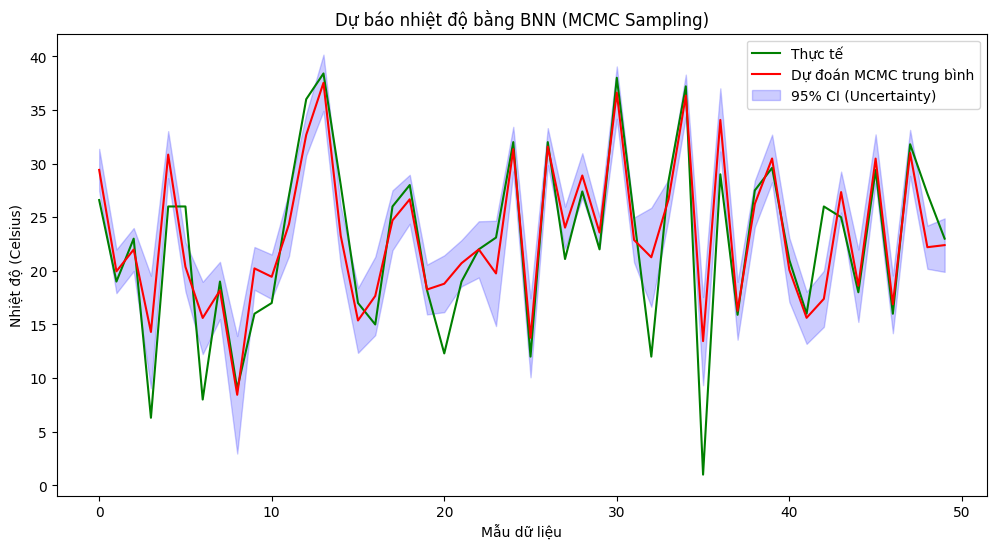

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(y_train[:50].numpy(), 'g-', label='Thực tế ')
plt.plot(y_mean, 'r-', label='Dự đoán MCMC trung bình')
plt.fill_between(range(50), y_mean - 2*y_std, y_mean + 2*y_std, color='blue', alpha=0.2, label='95% CI (Uncertainty)')
plt.title("Dự báo nhiệt độ bằng BNN (MCMC Sampling)")
plt.xlabel("Mẫu dữ liệu")
plt.ylabel("Nhiệt độ (Celsius)")
plt.legend()
plt.show()